## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [65]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [66]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [67]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#print(y_train), binary classification problem

(800, 2) (800,)
(200, 2) (200,)


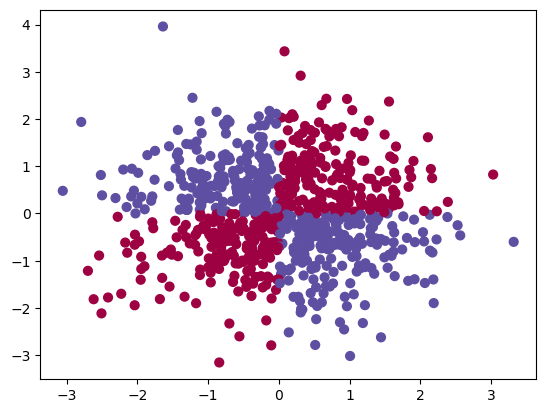

In [68]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

Written by my professor.

----------------------------------------------------------------------------------------------------------------------------------------------------

Architecture of the network:

__I will be using 2 input neurons, 4 neurons in the first hidden layer, 2 neurons in the second hidden layer, and 1 output neuron.__

For both of the hidden layers, I will be using the ReLu activation function.

For the output layer, I will be using the Logistic Sigmoid activation function.

For backprop, I will be using the Cross Entropy Loss and regular SGD (mini-batch if I can get it working).

----------------------------------------------------------------------------------------------------------------------------------------------------

Let's define the functions we will be using for each layer and backprop:

Cross Entropy Loss: $E(w) = - \sum_{n=1}^N (t_n \ln{y_n} + (1-t_n) \ln{(1-y_n)})$

Cross Entropy Loss Derivative: $\frac{\partial E}{\partial y_n} = -(\frac{t_n}{y_n} - \frac{1-t_n}{1-y_n})$

ReLu Function: $f(x) = \max{(0,a)}$

ReLu Derivative Function $f'(x) = \left\{\begin{array}{ll}1 & \text{if } x > 0 \\0 & \text{if } x \leq 0\end{array}\right.$

Logistic Sigmoid: $\sigma{(x)} = \frac{1}{1+e^{-x}}$

Logistic Sigmoid Derivative: $\sigma'{(x)} = \sigma{(x)}(1-\sigma{(x)})$

In [69]:
def relu(x):
    return np.maximum(0,x)

def relu_d(x):
    return np.where(x>0,1,0)

def sig(x):
    return 1/(1+np.exp(-x))

def sigd(x): #will not be used
    return sig(x)*(1-sig(x))

Then I will define the forward pass, back prop, and mini-batch sgd algorithm.

__Detailed Structure and Mathematics of the Network:__

$a_j^{(1)} = \sum_{i=1}^{D} w_{ji}^{(1)} x_i + w_{j0}^{(1)}$ for $j = 1, \ldots ,M$ In this case, $D=3,M=5$

$z_j^{(1)} = h(a_j^{(1)})$ for $h(\cdot)$ is the RELU activation function. This is hidden layer 1.

$a_k^{(2)} = \sum_{j=1}^{M} w_{kj}^{(2)} z_j^{(1)} + w_{k0}^{(2)}$ for $k = 1, \ldots ,K$ In this case, $M=5,K=3$

$z_j^{(2)} = h(a_k^{(2)})$ for $h(\cdot)$ is the RELU activation function. This is hidden layer 2.

$a_l^{(3)} = \sum_{k=1}^{M} w_{lk}^{(3)} z_k^{(2)} + w_{l0}^{(3)}$ for $l = 1, \ldots ,L$ In this case, $K=3,L=1$

$z_l^{(3)} = h(a_l^{(3)})$ for $h(\cdot)$ is the Logistic Sigmoid activation function. This is the output layer.


Full chains for gradients:

Output -> $W^{(3)}$: $\frac{\partial E}{\partial W^{(3)}} = \frac{\partial E}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial a_l^{(3)}} \frac{\partial a_l^{(3)}}{\partial W^{(3)}}$

Output -> $W^{(2)}$: $\frac{\partial E}{\partial W^{(2)}} = \frac{\partial E}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial a_l^{(3)}} \frac{\partial a_l^{(3)}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial a_k^{(2)}} \frac{\partial a_k^{(2)}}{\partial W^{(2)}}$

Output -> $W^{(1)}$: $\frac{\partial E}{\partial W^{(1)}} = \frac{\partial E}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial a_l^{(3)}} \frac{\partial a_l^{(3)}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial a_k^{(2)}} \frac{\partial a_k^{(1)}}{\partial z^{(1)}} \frac{\partial z^{(1)}}{\partial a_j^{(1)}} \frac{\partial a_j^{(1)}}{W^{(1)}}$

So let...

$\delta^{(3)} = \frac{\partial E}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial a_l^{(3)}} = \frac{\partial E}{\partial z^{(3)}} h'(a_l^{(3)}) $

$\delta^{(2)} = \frac{\partial E}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial a_l^{(3)}} \frac{\partial a_l^{(3)}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial a_k^{(2)}} = \delta^{(3)} W^{(3)} h'(a_k^{(2)})$

$\delta^{(1)} = \frac{\partial E}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial a_l^{(3)}} \frac{\partial a_l^{(3)}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial a_k^{(2)}} \frac{\partial a_k^{(1)}}{\partial z^{(1)}} \frac{\partial z^{(1)}}{\partial a_j^{(1)}} = \delta^{(2)} W^{(2)} h'(a_j^{(1)})$

Thus...

$\frac{\partial E}{\partial W^{(3)}} = \frac{\partial a_l^{(3)}}{\partial W^{(3)}} \delta^{(3)}  = (z_k^{(2)})^T \delta^{(3)} $

$\frac{\partial E}{\partial W^{(2)}} = (z_j^{(1)})^T (h'(a_k^{(2)}) (\delta^{(3)} (W^{(3)})^T)) $

$\frac{\partial E}{\partial W^{(1)}} = (x_i)^T (h'(a_j^{(1)}) (\delta^{(2)} (W^{(2)})^T)) $ 

Now we code all of this info below:

In [ ]:
def forward(X,w1,w2,w3):
    Xc = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1) #input + bias
    aj = Xc @ w1  #pre-activation 1
    z1 = relu(aj) #activation 1
    z1c = np.concatenate([z1, np.ones((z1.shape[0], 1))], axis=1)
    ak = z1c @ w2 #pre-activation 2
    z2 = relu(ak) #activation 2
    z2c = np.concatenate([z2, np.ones((z2.shape[0], 1))], axis=1)
    al = z2c @ w3 #pre-activtion 3
    z3 = sig(al) #output (after activation 3)
    return Xc,aj,z1c,ak,z2c,z3

def gradients(Xc,t,o,w2,w3,aj,ak,z1c,z2c):
    t = t.reshape(-1, 1)
    delta_3 = o - t
    delta_2 = relu_d(ak) *(delta_3 @ w3[:-1].T)
    delta_1 = relu_d(aj) * (delta_2 @ w2[:-1].T)
    dw3 = z2c.T @ delta_3
    dw2 = z1c.T @ delta_2
    dw1 = Xc.T @ delta_1
    return dw3, dw2, dw1

For now we will use SGD just to see if this code is working properly.
That is,

$W^{(l)} := W^{(l)} - \eta \frac{\partial E}{\partial W^{(l)}}$


In [ ]:
def sgd(W,dw,eta): #stoachastic gradient descent function
    new_weights = []
    for W_i, dw_i in zip(W,dw):
        newW = W_i - eta*dw_i
        new_weights.append(newW)
    return new_weights

This is through regular SGD:

In [72]:
'''def train(X,t,eta,epochs):
    w1 = np.random.randn(X.shape[1]+1, 4)
    w2 = np.random.randn(4+1, 3)
    w3 = np.random.randn(3+1, 1)

    for epoch in range(epochs):
        Xc, aj, z1c, ak, z2c, z3 = forward(X,w1,w2,w3)
        dw3, dw2, dw1 = gradients(Xc, t, z3, w2, w3, aj, ak, z1c, z2c)
        w1,w2,w3 = sgd([w1,w2,w3], [dw1,dw2,dw3], eta)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss = {np.mean(np.square(z3 - y_train))}")
    return z3, w1, w2, w3'''

'def train(X,t,eta,epochs):\n    w1 = np.random.randn(X.shape[1]+1, 4)\n    w2 = np.random.randn(4+1, 3)\n    w3 = np.random.randn(3+1, 1)\n\n    for epoch in range(epochs):\n        Xc, aj, z1c, ak, z2c, z3 = forward(X,w1,w2,w3)\n        dw3, dw2, dw1 = gradients(Xc, t, z3, w2, w3, aj, ak, z1c, z2c)\n        w1,w2,w3 = sgd([w1,w2,w3], [dw1,dw2,dw3], eta)\n        if epoch % 1000 == 0:\n            print(f"Epoch {epoch}: Loss = {np.mean(np.square(z3 - y_train))}")\n    return z3, w1, w2, w3'

This is SGD, but the assigment says to use mini-batch SGD. We wil implement this next:

Input: $w^{(l)}$, learning rate $\eta_k \geq 0$, max number of iterations $k$


for $k = 0, \ldots,k-1$

Randomly select a batch $B_k \subset \{1,\ldots,N\}$ where $|B_k| << N$

In [ ]:
def train_mini_batch(X,t,eta,epochs,batch_size):
    w1 = np.random.randn(X.shape[1]+1, 4) #+1 for bias
    w2 = np.random.randn(4+1, 3)
    w3 = np.random.randn(3+1, 1)

    t = t.reshape(-1,1) #since t.T doesn't do anything we must do this to make t a column vector
    N = X.shape[0]

    for epoch in range(epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = X[indices]
        t = t[indices] #shuffles both inputs and target

        for i in range(0,N,batch_size):
            X_batch = X[i:i+batch_size] #setting the length of a batch
            t_batch = t[i:i+batch_size]

            Xc, aj, z1c, ak, z2c, z3 = forward(X_batch,w1,w2,w3)
            dw3, dw2, dw1 = gradients(Xc, t_batch, z3, w2, w3, aj, ak, z1c, z2c)
            w1,w2,w3 = sgd([w1,w2,w3], [dw1,dw2,dw3], eta)
        if epoch % 1000 == 0:
            _, _, _, _, _, z3_full = forward(X, w1, w2, w3)
            eps = 1e-8
            loss = -np.mean(t * np.log(z3_full + eps) + (1 - t) * np.log(1 - z3_full + eps))
            print(f"Epoch {epoch}: Loss = {loss:.6f}, z3 mean = {np.mean(z3_full):.4f}")
    return z3_full, w1, w2, w3

_,w1,w2,w3 = train_mini_batch(X_train,y_train,0.01,10000,32) #output of fully trained weights
_,_,_,_,_,z3_test = forward(X_test,w1,w2,w3) #using foward pass on X_test, with trained weights
y_pred = (z3_test > 0.5).astype(int) #checks if each output is >0.5 (true if it is, false if not), then assign 1 to true and 0 to false kind of like rounding

Epoch 0: Loss = 0.687439, z3 mean = 0.5071
Epoch 1000: Loss = 0.041617, z3 mean = 0.5091
Epoch 2000: Loss = 0.012065, z3 mean = 0.5120
Epoch 3000: Loss = 0.013875, z3 mean = 0.5122
Epoch 4000: Loss = 0.006220, z3 mean = 0.5133
Epoch 5000: Loss = 0.000632, z3 mean = 0.5166
Epoch 6000: Loss = 0.000128, z3 mean = 0.5163
Epoch 7000: Loss = 0.000070, z3 mean = 0.5163
Epoch 8000: Loss = 0.000041, z3 mean = 0.5163
Epoch 9000: Loss = 0.000031, z3 mean = 0.5163


Now we score the prediction (Accuracy, Precision, Recall, F1) with the y_test outputs.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#compares predictions with test target values and scores them

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

print("accuracy: ", accuracy)
print("precision: ",precision)
print("recall", recall)
print("f1:", f1)

accuracy:  1.0
precision:  1.0
recall 1.0
f1: 1.0


The model is perfect and it scored 100% on all scores. Demonstrates the strength of my neural network model. Now we plot the decision boundary (optional).

Confusion matrix:
 [[ 97   0]
 [  0 103]]


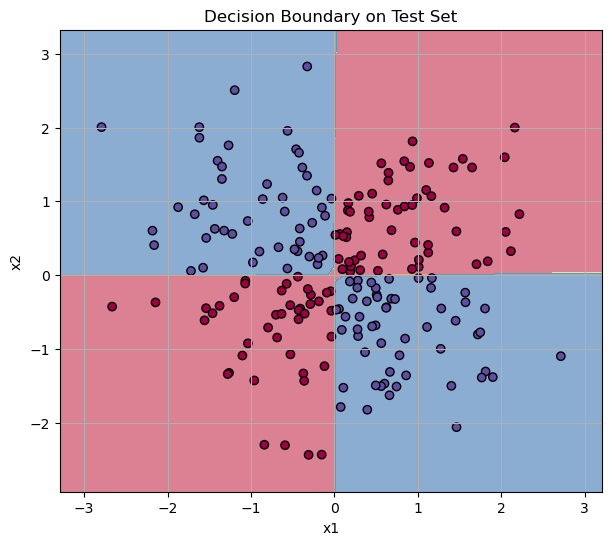

In [75]:
from sklearn.metrics import confusion_matrix
#Displaying a matrix with [[True Negatives, False Positives], [False Negatives, True Positives] ]
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

#Creating a grid over the feature space
h = 0.01
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#Predicting class for each point in the grid
grid = np.c_[xx.ravel(), yy.ravel()]
_, _, _, _, _, z3_grid = forward(grid, w1, w2, w3)
Z = (z3_grid > 0.5).astype(int).reshape(xx.shape)

#Plotting the decision boundary and test points
plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, edgecolors='k')
plt.title("Decision Boundary on Test Set")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()